In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras.datasets
import matplotlib.pyplot as plt

In [ ]:
(x_train,y_train),(x_test,y_test) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
def preprocess(dataset):
  dataset = (dataset - 127.5) / 127.5

  return dataset


In [ ]:
x_train  = preprocess(x_train)

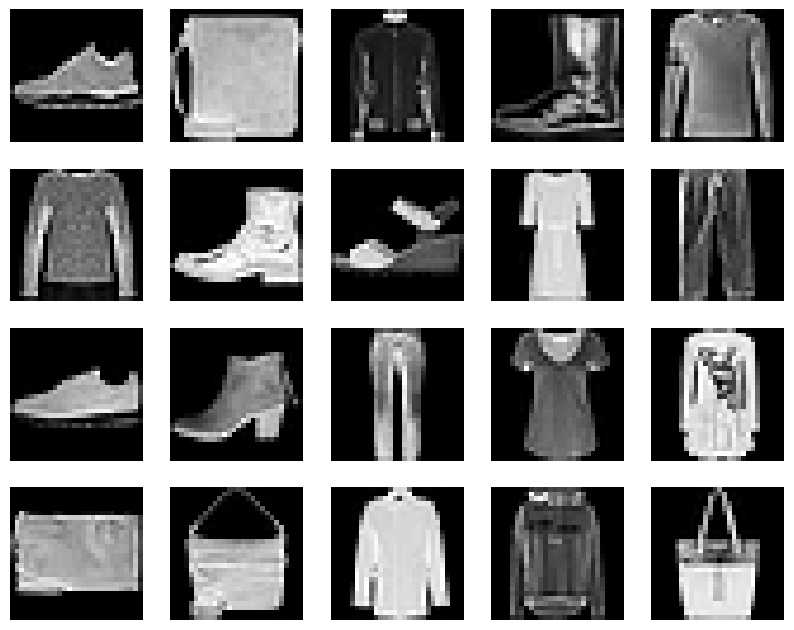

In [ ]:
fig  = plt.figure(figsize = (10,10))

for n , i in enumerate(list(np.random.randint(0 ,x_train.shape[0],20))):
    plt.subplot(5,5,n+1)
    plt.imshow(x_train[i], cmap = "gray")
    plt.axis('off')

In [ ]:
# the discriminator

dis_input = keras.layers.Input(shape = (28,28,1))
x = keras.layers.Conv2D(28,kernel_size = 4,strides = 2, padding = 'same',use_bias = False)(dis_input)
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Conv2D(56,kernel_size = 4,strides = 2, padding = 'same',use_bias = False)(x)
x = keras.layers.BatchNormalization(momentum= 0.9)(x)
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Conv2D(112,kernel_size = 4,strides = 2, padding = 'same',use_bias = False)(x)
x = keras.layers.BatchNormalization(momentum= 0.9)(x)
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Conv2D(1,kernel_size = 4,strides = 1 ,padding = 'valid', activation = "sigmoid" ,use_bias = False)(x)
dis_output = keras.layers.Flatten()(x)

discriminator = keras.models.Model(dis_input,dis_output)

In [ ]:
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 28)        448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 28)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 28)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 56)          25088     
                                                                 
 batch_normalization (Batch  (None, 7, 7, 56)          224       
 Normalization)                                                  
                                                             

In [ ]:
#the generator
dimentions = 100
gen_input = keras.layers.Input(shape = (dimentions,))
x = keras.layers.Reshape((1,1,dimentions))(gen_input)
x = keras.layers.Conv2DTranspose(112,kernel_size = 4,strides = 1 ,padding = 'valid',use_bias = False)(x)
x = keras.layers.BatchNormalization(momentum= 0.9)(x)
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Conv2DTranspose(56,kernel_size = 4,strides = 2 ,padding = 'same',use_bias = False)(x)
x = keras.layers.BatchNormalization(momentum= 0.9)(x)
x = keras.layers.LeakyReLU(0.2)(x)
x = keras.layers.Conv2DTranspose(28,kernel_size = 4,strides = 2 ,padding = 'same',use_bias = False)(x)
x = keras.layers.BatchNormalization(momentum= 0.9)(x)
x = keras.layers.LeakyReLU(0.2)(x)
gen_output = keras.layers.Conv2DTranspose(1, kernel_size =13, strides = 1, padding = "valid", use_bias = False ,activation = 'tanh')(x)

generator_model = keras.models.Model(gen_input,gen_output)

In [ ]:
generator_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 112)         179200    
 anspose)                                                        
                                                                 
 batch_normalization_2 (Bat  (None, 4, 4, 112)         448       
 chNormalization)                                                
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4, 4, 112)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 56)          1003

In [ ]:
class GAN(keras.models.Model):
  def __init__(self,gen,dis,latent_dim):
    super(GAN,self).__init__()
    self.genetrator = gen
    self.discriminator = dis
    self.latent_dim = latent_dim

  def compile(self,d_optimizer,g_optimizer):

    super(GAN,self).compile()

    self.loss_fun = keras.losses.BinaryCrossentropy()
    self.g_optimizer = g_optimizer
    self.d_optimizer = d_optimizer

    self.g_loss_metric = keras.metrics.Mean(
        name = "generator_loss")
    self.d_loss_metric = keras.metrics.Mean(
        name = "discriminator_loss")

    self.d_real_accuracy = keras.metrics.BinaryAccuracy(
        name = "discriminator_real_accuracy")
    self.d_fake_accuracy = keras.metrics.BinaryAccuracy(
        name = "discriminator_fake_accuracy")

    self.d_accuracy = keras.metrics.BinaryAccuracy(
        name = "discrimivator_accuracy")
    self.g_accuracy = keras.metrics.BinaryAccuracy(
        name = "genetrator_accuracy")

  @property
  def metrics(self):
    return [
    self.g_loss_metric,
    self.d_loss_metric ,
    self.d_real_accuracy ,
    self.d_fake_accuracy,
    self.d_accuracy ,
    self.g_accuracy
    ]

  def train_step(self,real_images):
    batch_size = real_images.shape[0]
    random_vector = tf.random.normal(
        shape = (batch_size,self.latent_dim))

    with tf.GradientTape() as gen_tape ,tf.GradientTape() as dis_tape:
      generated_images = self.genetrator(
          random_vector , training = True)

      real_predicitons = self.discriminator(
          real_images , training = True)
      fake_predictions = self.discriminator(
          generated_images , training = True)

      real_labels = tf.ones_like(real_predicitons)
      fake_labels = tf.ones_like(fake_predictions)

      real_noise_labels = real_labels + 0.1 * tf.random.uniform(
          tf.shape(real_predicitons))
      fake_noise_labels = fake_labels + 0.1 * tf.random.uniform(
          tf.shape(fake_predictions))

      dis_loss_real = self.loss_fun(
          real_noise_labels,real_predicitons)
      dis_loss_fake = self.loss_fun(
          fake_noise_labels,fake_predictions)

      dis_loss = (dis_loss_real + dis_loss_fake) / 2.0

      gen_loss = self.loss_fun(real_labels,fake_predictions)

      gradient_discriminator = dis_tape.gradient(
          dis_loss,self.discriminator.trainable_variables)

      self.d_optimizer.apply_gradients(
          zip(gradient_discriminator, self.discriminator.trainable_variables))

      gradient_generator = gen_tape.gradient(
          gen_loss,self.genetrator.trainable_variables)

      self.g_optimizer.apply_gradients(
          zip(gradient_generator, self.genetrator.trainable_variables))

      self.d_loss_metric.update_state(dis_loss)
      self.g_loss_metric.update_state(gen_loss)
      self.d_fake_accuracy.update_state(fake_labels,fake_predictions)
      self.d_real_accuracy.update_state(real_labels,real_predicitons)
      self.d_accuracy.update_state(
          [real_labels,fake_labels],
           [real_predicitons,fake_predictions])
      self.g_accuracy(real_labels,fake_predictions)

      return {m.name: m.result() for m in self.metrics}



In [ ]:
gan = GAN(dis = discriminator,gen = generator_model, latent_dim = dimentions)

In [ ]:
gan.compile(
    g_optimizer= keras.optimizers.Adam(
      learning_rate=0.002 ,beta_1= 0.5,beta_2= 0.999),
    d_optimizer= keras.optimizers.Adam(
        learning_rate=0.0002,beta_1= 0.5,beta_2= 0.999))

In [ ]:
check_point = keras.callbacks.ModelCheckpoint(
    save_weight_only = True,
    filepath='/content/drive/MyDrive/gan_checkpoint',save_freq="epoch")

In [ ]:
gan.fit(x_train,epochs= 100,batch_size= 32)

Epoch 1/100
1875/1875 [==============================] - 16s 9ms/step - generator_loss: 0.0000e+00 - discriminator_loss: -0.7620 - discriminator_real_accuracy: 1.0000 - discriminator_fake_accuracy: 1.0000 - discrimivator_accuracy: 1.0000 - genetrator_accuracy: 1.0000
Epoch 2/100
1875/1875 [==============================] - 15s 8ms/step - generator_loss: 0.0000e+00 - discriminator_loss: -0.7616 - discriminator_real_accuracy: 1.0000 - discriminator_fake_accuracy: 1.0000 - discrimivator_accuracy: 1.0000 - genetrator_accuracy: 1.0000
Epoch 3/100
1875/1875 [==============================] - 15s 8ms/step - generator_loss: 0.0000e+00 - discriminator_loss: -0.7620 - discriminator_real_accuracy: 1.0000 - discriminator_fake_accuracy: 1.0000 - discrimivator_accuracy: 1.0000 - genetrator_accuracy: 1.0000
Epoch 4/100
1875/1875 [==============================] - 15s 8ms/step - generator_loss: 0.0000e+00 - discriminator_loss: -0.7613 - discriminator_real_accuracy: 1.0000 - discriminator_fake_accuracy

KeyboardInterrupt: ignored

In [ ]:
z_samples = tf.random.normal(shape = (30,dimentions))

In [ ]:
generations = generator_model.predict(z_samples)

1/1 [==============================] - 0s 17ms/step


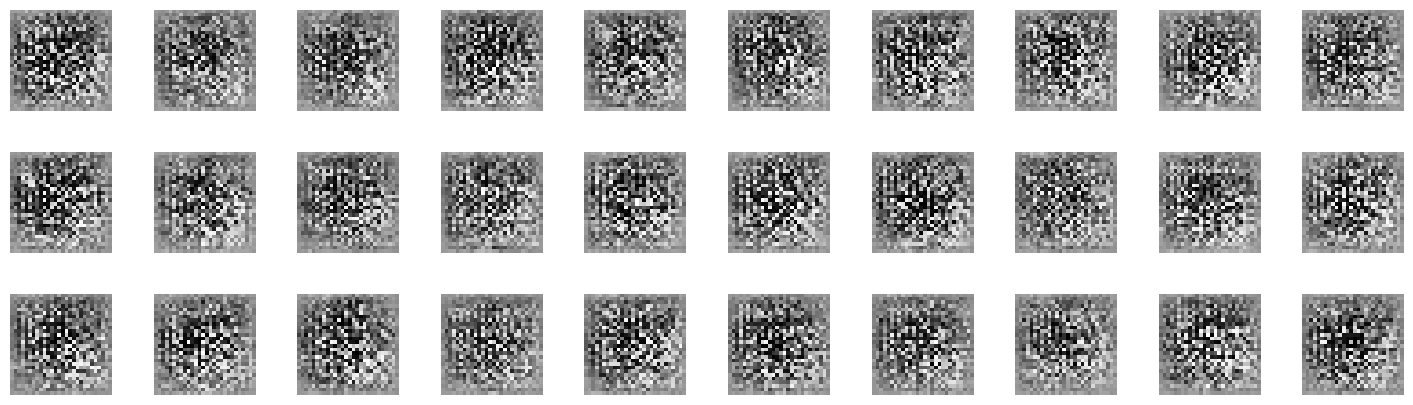

In [ ]:
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1)
    ax.axis("off")
    ax.imshow(generations[i, :, :], cmap="Greys")